In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision import datasets, transforms, models
import torchvision
import torchvision.transforms.functional as TF

# optional: additional model zoo (ViT variants etc.)
try:
    import timm  # pip install timm
except Exception:
    timm = None

import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
model, preprocess = clip.load("ViT-B/32", device=device)

# --- Test with a single image and prompt ---
# Download a sample CIFAR-10 image
cifar10 = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
sample_img, sample_label = cifar10[0]  # First test image

# Preprocess image (CLIP expects 224x224 RGB)
image_input = preprocess(sample_img).unsqueeze(0).to(device)

# Define text prompts
class_names = cifar10.classes
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)

# Get embeddings
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

    # Normalize for cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarities
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Predicted class
pred_idx = similarity.argmax().item()
print(f"True label: {class_names[sample_label]}")
print(f"Predicted label: {class_names[pred_idx]}")

True label: cat
Predicted label: cat


In [3]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

# Preprocess CIFAR-10 for CLIP (resize to 224x224)
transform_clip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_clip
)

test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)

# Encode all text prompts once
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating CLIP on CIFAR-10"):
        images = images.to(device)

        # Encode images
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Compute similarity
        similarity = image_features @ text_features.T
        preds = similarity.argmax(dim=1).cpu().numpy()

        correct += (preds == labels.numpy()).sum()
        total += labels.size(0)

acc = correct / total * 100
print(f"Zero-shot CLIP ViT-B/32 accuracy on CIFAR-10: {acc:.2f}%")


Evaluating CLIP on CIFAR-10:   0%|          | 0/157 [00:00<?, ?it/s]

Zero-shot CLIP ViT-B/32 accuracy on CIFAR-10: 84.74%


In [4]:
from torch.utils.data import DataLoader

cifar10_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=preprocess
)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)


In [5]:
class_names = cifar10_test.classes
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [6]:
correct, total = 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Zero-shot CIFAR-10"):
        images = images.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = image_features @ text_features.T
        preds = similarity.argmax(dim=1).cpu().numpy()

        correct += (preds == labels.numpy()).sum()
        total += labels.size(0)

acc = correct / total * 100
print(f"Zero-shot CLIP ViT-B/32 accuracy on CIFAR-10: {acc:.2f}%")


Zero-shot CIFAR-10:   0%|          | 0/157 [00:00<?, ?it/s]

Zero-shot CLIP ViT-B/32 accuracy on CIFAR-10: 88.72%


PACS Zero Shot on Sketches/Cartoons

In [7]:
import pandas as pd
from datasets import load_dataset

model, preprocess = clip.load("ViT-B/32", device=device)

# --- PACS loader function ---
def load_pacs_from_hf(test_domain="sketch", batch_size=64, test_size=0.3):
    """
    Load PACS from HuggingFace and split by domain.
    test_domain: one of ["sketch", "cartoon", "photo", "art_painting"]
    """
    # PACS only has a 'train' split
    ds = load_dataset("flwrlabs/pacs", split="train")

    # Filter by domain
    ds = ds.filter(lambda x: x["domain"] == test_domain)

    # Create train/test subsets (70/30)
    ds_split = ds.train_test_split(test_size=test_size, seed=42)

    # Define transform for CLIP
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711]),
    ])

    def transform_fn(examples):
        images = []
        labels = []
        for img, lbl in zip(examples["image"], examples["label"]):
            img = img.convert("RGB")
            img = transform(img)
            images.append(img)
            labels.append(lbl)
        return {"pixel_values": images, "labels": labels}


    ds_split = ds_split.with_transform(transform_fn)

    # Use only the test part for evaluation
    loader = torch.utils.data.DataLoader(
        ds_split["test"], batch_size=batch_size, shuffle=False
    )

    classes = ds.features["label"].names
    return loader, classes

# -------------------------------
# Build text features for zero-shot
# -------------------------------
def build_text_features(prompt_templates, classnames):
    text_features = {}
    for tmpl in prompt_templates:
        texts = [tmpl.format(c.replace("_", " ")) for c in classnames]
        tokenized = clip.tokenize(texts).to(device)
        with torch.no_grad():
            emb = model.encode_text(tokenized)
            emb /= emb.norm(dim=-1, keepdim=True)
        text_features[tmpl] = emb
    return text_features

# -------------------------------
# Evaluation function
# -------------------------------
def evaluate(loader, text_features_dict, prompt_templates, classes):
    correct = {tmpl: 0 for tmpl in prompt_templates}
    total = 0

    for batch in loader:
        images, labels = batch["pixel_values"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        for tmpl in prompt_templates:
            text_features = text_features_dict[tmpl]
            logits = 100.0 * image_features @ text_features.T
            preds = torch.argmax(logits, dim=-1)
            correct[tmpl] += (preds == labels).sum().item()

        total += labels.size(0)

    accs = {tmpl: 100 * correct[tmpl] / total for tmpl in prompt_templates}
    return accs

# -------------------------------
# Main Experiment
# -------------------------------
prompt_templates = [
    "a photo of a {}",
    "a sketch of a {}",
    "a cartoon of a {}",
]

# Run on Sketch + Cartoon
for domain in ["sketch", "cartoon"]:
    print(f"\n=== Evaluating on PACS domain: {domain.upper()} ===")

    loader, pacs_classes = load_pacs_from_hf(test_domain=domain)
    text_features_dict = build_text_features(prompt_templates, pacs_classes)

    accs = evaluate(loader, text_features_dict, prompt_templates, pacs_classes)

    for tmpl, acc in accs.items():
        print(f"Prompt: '{tmpl}' -> Accuracy: {acc:.2f}%")


=== Evaluating on PACS domain: SKETCH ===
Prompt: 'a photo of a {}' -> Accuracy: 85.50%
Prompt: 'a sketch of a {}' -> Accuracy: 86.26%
Prompt: 'a cartoon of a {}' -> Accuracy: 84.65%

=== Evaluating on PACS domain: CARTOON ===
Prompt: 'a photo of a {}' -> Accuracy: 98.15%
Prompt: 'a sketch of a {}' -> Accuracy: 97.59%
Prompt: 'a cartoon of a {}' -> Accuracy: 97.44%



Query: a photo of a cat
  Top-1 match: 3 (conf: 0.43)
  Top-2 match: 6 (conf: 0.43)
  Top-3 match: 6 (conf: 0.05)


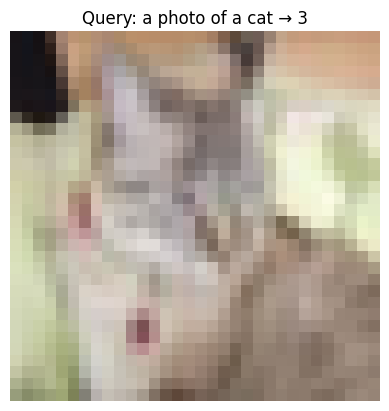


Query: a photo of a dog
  Top-1 match: 5 (conf: 0.40)
  Top-2 match: 6 (conf: 0.36)
  Top-3 match: 5 (conf: 0.16)


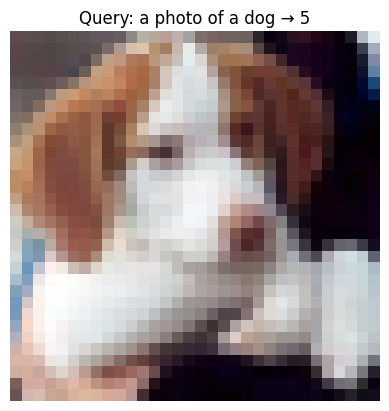


Query: a photo of a car
  Top-1 match: 1 (conf: 0.86)
  Top-2 match: 1 (conf: 0.07)
  Top-3 match: 8 (conf: 0.02)


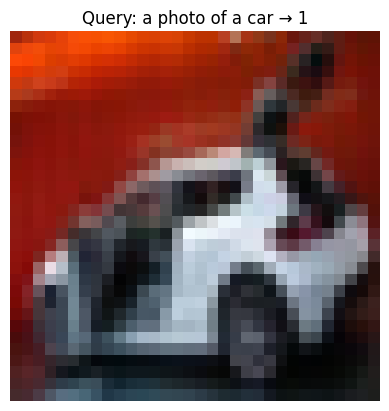


Query: a photo of an airplane
  Top-1 match: 0 (conf: 0.86)
  Top-2 match: 0 (conf: 0.10)
  Top-3 match: 8 (conf: 0.01)


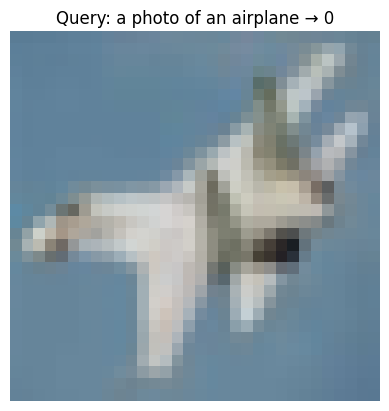


Query: a cartoon of a horse
  Top-1 match: 7 (conf: 0.63)
  Top-2 match: 7 (conf: 0.32)
  Top-3 match: 6 (conf: 0.01)


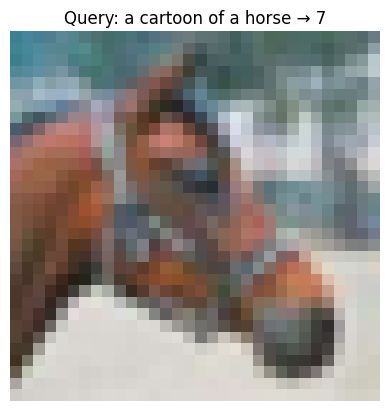


Query: a sketch of a bird
  Top-1 match: 6 (conf: 0.81)
  Top-2 match: 6 (conf: 0.06)
  Top-3 match: 0 (conf: 0.05)


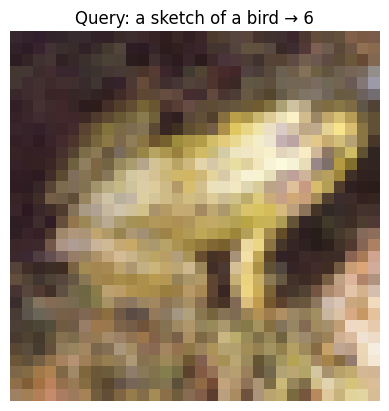

In [8]:
import matplotlib.pyplot as plt

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
#                          (0.26862954, 0.26130258, 0.27577711))
# ])
# cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=preprocess)

# # Pick 20 random samples
# indices = np.random.choice(len(cifar_test), 20, replace=False)
# sample_images = [cifar_test[i][0] for i in indices]
# sample_labels = [cifar_test.classes[cifar_test[i][1]] for i in indices]

# Load CIFAR-10 without transform to keep PIL images
cifar10_raw = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=None)

# Pick sample images (PIL format)
indices = list(range(20))  # first 20 for retrieval
sample_images = [cifar10_raw[i][0] for i in indices]  # PIL images
sample_labels = [cifar10_raw[i][1] for i in indices]

# Now preprocess correctly
with torch.no_grad():
    image_inputs = torch.stack([preprocess(img) for img in sample_images]).to(device)
    image_features = model.encode_image(image_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)


# 2. Encode image embeddings
with torch.no_grad():
    image_inputs = torch.stack([preprocess(img) for img in sample_images]).to(device)
    image_features = model.encode_image(image_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)

# 3. Define text queries
text_queries = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of an airplane",
    "a cartoon of a horse",
    "a sketch of a bird"
]
text_tokens = clip.tokenize(text_queries).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 4. Compute cosine similarity
similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)

# 5. Retrieval Results
for i, query in enumerate(text_queries):
    top_probs, top_idxs = similarity[i].topk(3)  # top-3 matches
    print(f"\nQuery: {query}")
    for rank, (idx, prob) in enumerate(zip(top_idxs.tolist(), top_probs.tolist()), 1):
        print(f"  Top-{rank} match: {sample_labels[idx]} (conf: {prob:.2f})")

    # Display top-1 retrieved image
    plt.imshow(sample_images[top_idxs[0]])
    plt.title(f"Query: {query} → {sample_labels[top_idxs[0]]}")
    plt.axis("off")
    plt.show()


=== Reverse Retrieval (Image → Text) ===
Image 0: Best match → 'a photo of a cat' (score: 0.21)


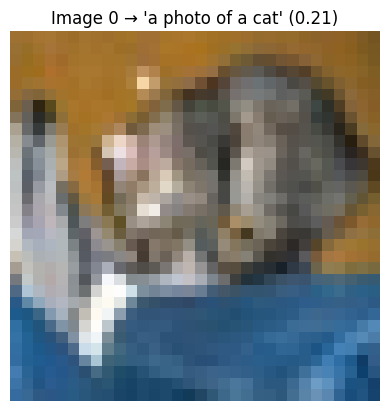

Image 1: Best match → 'a photo of a car' (score: 0.20)


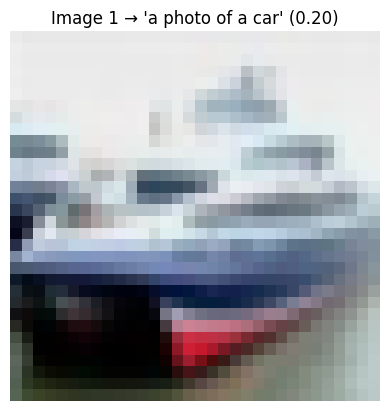

Image 2: Best match → 'a photo of a car' (score: 0.22)


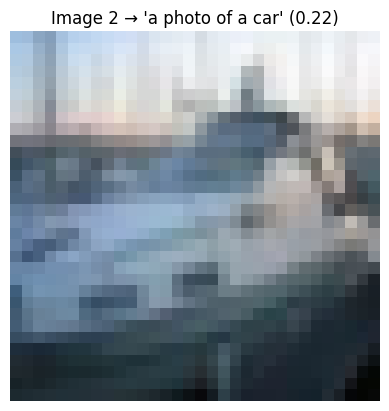

Image 3: Best match → 'a photo of an airplane' (score: 0.24)


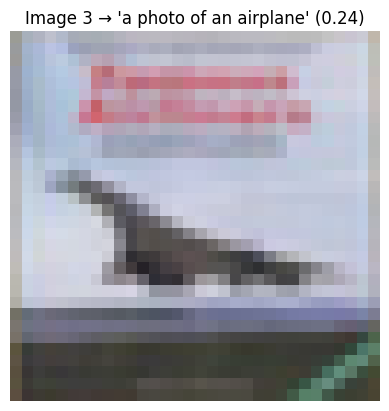

Image 4: Best match → 'a photo of a cat' (score: 0.22)


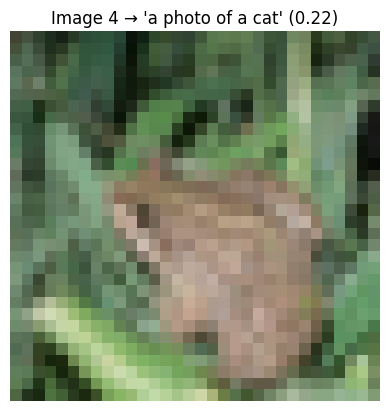

Image 5: Best match → 'a photo of a cat' (score: 0.26)


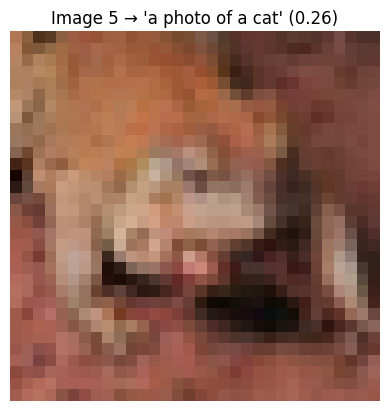

Image 6: Best match → 'a photo of a car' (score: 0.26)


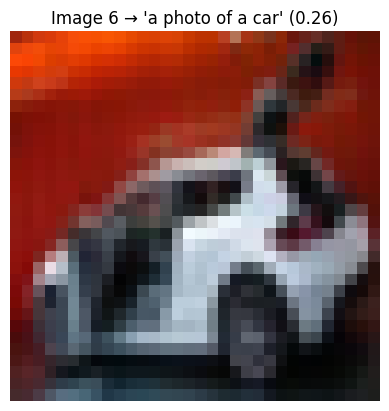

Image 7: Best match → 'a photo of a dog' (score: 0.22)


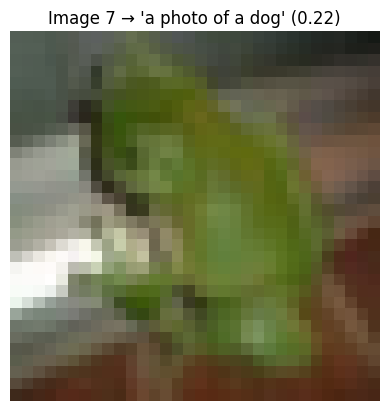

Image 8: Best match → 'a photo of a cat' (score: 0.26)


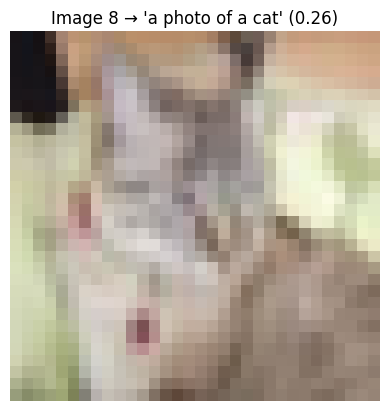

Image 9: Best match → 'a photo of a car' (score: 0.24)


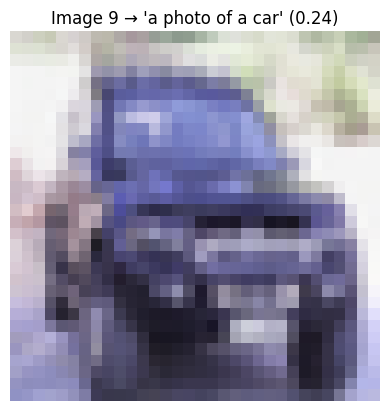

Image 10: Best match → 'a photo of an airplane' (score: 0.26)


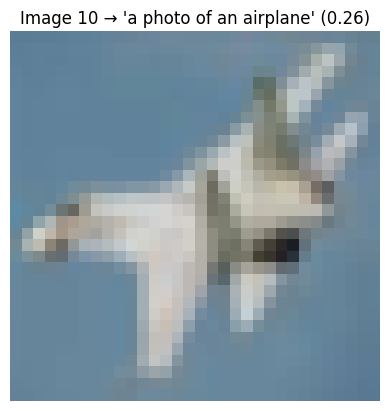

Image 11: Best match → 'a photo of a car' (score: 0.21)


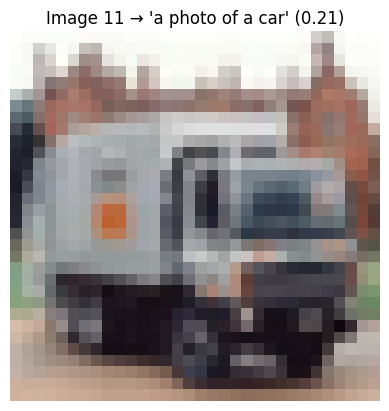

Image 12: Best match → 'a photo of a dog' (score: 0.25)


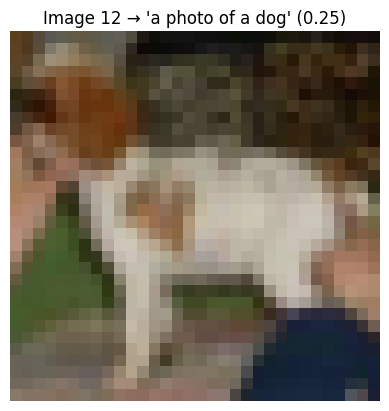

Image 13: Best match → 'a cartoon of a horse' (score: 0.25)


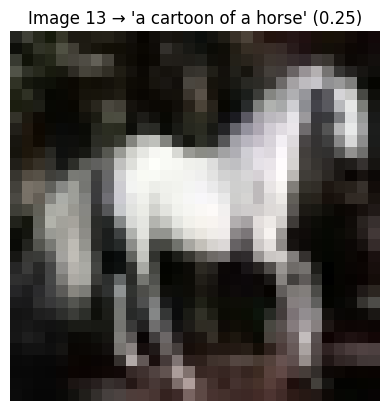

Image 14: Best match → 'a photo of a car' (score: 0.21)


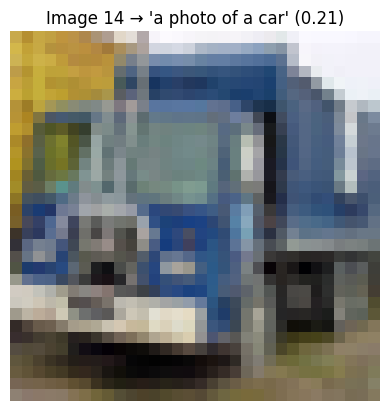

Image 15: Best match → 'a photo of an airplane' (score: 0.22)


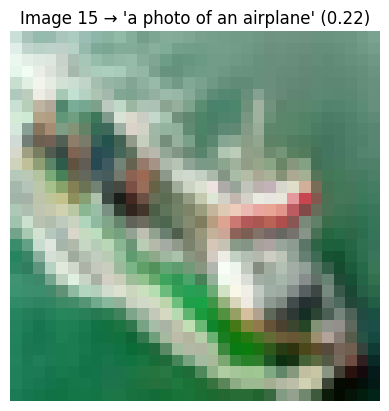

Image 16: Best match → 'a photo of a dog' (score: 0.26)


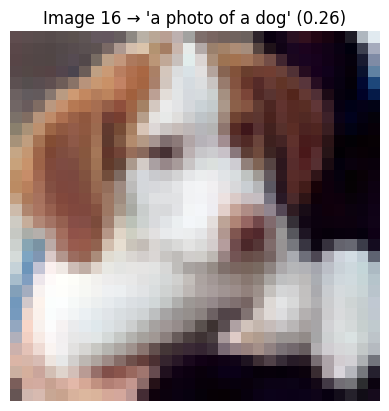

Image 17: Best match → 'a cartoon of a horse' (score: 0.26)


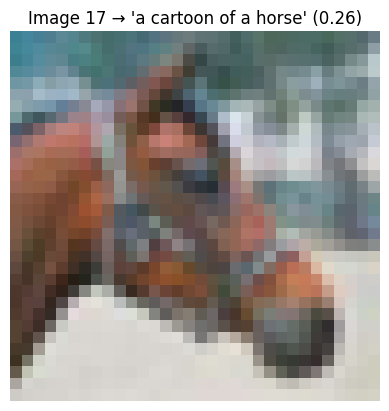

Image 18: Best match → 'a photo of a dog' (score: 0.19)


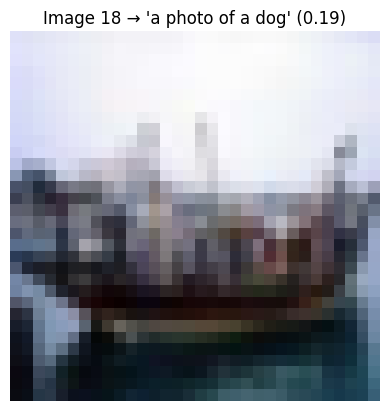

Image 19: Best match → 'a photo of a cat' (score: 0.24)


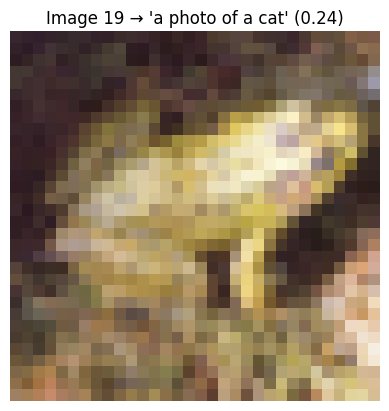

In [9]:
# --- Reverse Retrieval: Image → Best matching text ---
print("\n=== Reverse Retrieval (Image → Text) ===")

# For each image, find the best matching text description
with torch.no_grad():
    sim_matrix = image_features @ text_features.T  # shape [num_images, num_texts]

for idx in range(len(sample_images)):
    sims = sim_matrix[idx].cpu().numpy()
    best_text_idx = sims.argmax()
    best_text = text_queries[best_text_idx]
    best_score = sims[best_text_idx]

    print(f"Image {idx}: Best match → '{best_text}' (score: {best_score:.2f})")

    # Display the image with the matched text
    plt.imshow(sample_images[idx])
    plt.axis("off")
    plt.title(f"Image {idx} → '{best_text}' ({best_score:.2f})")
    plt.show()


In [10]:
import pandas as pd

# Build similarity matrix
with torch.no_grad():
    sim_matrix = image_features @ text_features.T  # [num_images, num_texts]

rows = []
for t_idx, query in enumerate(text_queries):
    # Text → Image
    sims_img = sim_matrix[:, t_idx].cpu().numpy()
    best_img_idx = sims_img.argmax()
    best_img_score = sims_img[best_img_idx]

    # Reverse: Image → Text
    sims_text = sim_matrix[best_img_idx].cpu().numpy()
    best_text_idx = sims_text.argmax()
    best_text = text_queries[best_text_idx]
    best_text_score = sims_text[best_text_idx]

    rows.append({
        "Query (Text → Image)": query,
        "Top-1 Retrieved Image": f"Image {best_img_idx}",
        "Confidence": round(float(best_img_score), 2),
        "Reverse Match (Image → Text)": best_text,
        "Score": round(float(best_text_score), 2)
    })

df = pd.DataFrame(rows)
print(df)

# Optional: pretty display in Jupyter
from IPython.display import display
display(df)


     Query (Text → Image) Top-1 Retrieved Image  Confidence  \
0        a photo of a cat               Image 8        0.26   
1        a photo of a dog              Image 16        0.26   
2        a photo of a car               Image 6        0.26   
3  a photo of an airplane              Image 10        0.26   
4    a cartoon of a horse              Image 17        0.26   
5      a sketch of a bird              Image 19        0.23   

  Reverse Match (Image → Text)  Score  
0             a photo of a cat   0.26  
1             a photo of a dog   0.26  
2             a photo of a car   0.26  
3       a photo of an airplane   0.26  
4         a cartoon of a horse   0.26  
5             a photo of a cat   0.24  


,Query (Text → Image),Top-1 Retrieved Image,Confidence,Reverse Match (Image → Text),Score
0,a photo of a cat,Image 8,0.26,a photo of a cat,0.26
1,a photo of a dog,Image 16,0.26,a photo of a dog,0.26
2,a photo of a car,Image 6,0.26,a photo of a car,0.26
3,a photo of an airplane,Image 10,0.26,a photo of an airplane,0.26
4,a cartoon of a horse,Image 17,0.26,a cartoon of a horse,0.26
5,a sketch of a bird,Image 19,0.23,a photo of a cat,0.24


Loading models...
Loading CIFAR-10 (raw PIL images)...
Collected 80 CIFAR images.
Loading PACS (HuggingFace) and sampling sketch/cartoon images...
Collected 60 sketch images and 60 cartoon images.
Creating grayscale versions (from CIFAR subset)...
Created 16 grayscale images.
Total images to embed: 216
Computing CLIP embeddings...
Computing ResNet embeddings...
Running PCA->t-SNE for CLIP features (this may take a moment)...
Running PCA->t-SNE for ResNet features...
Plotting results...


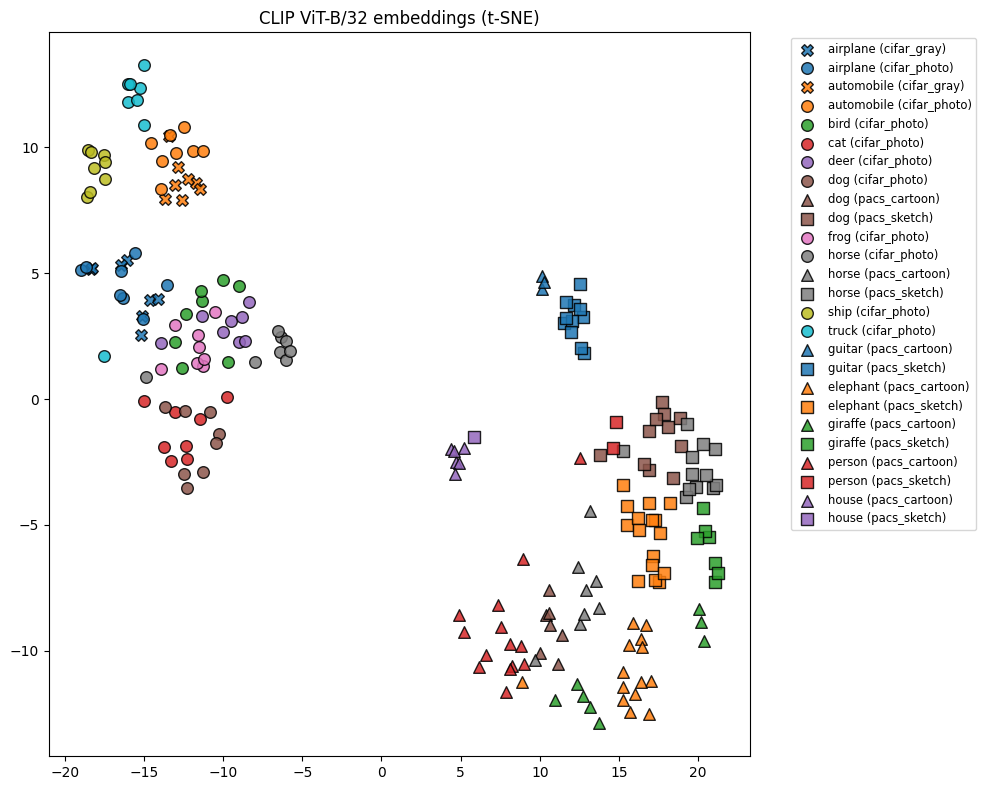

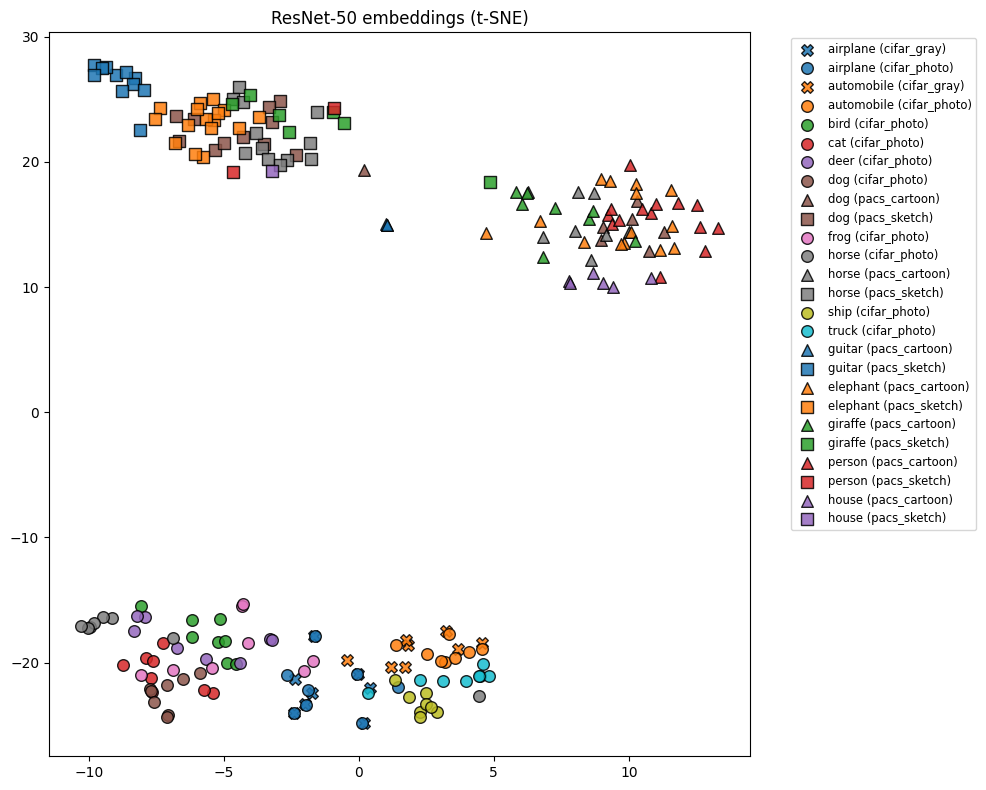


Average intra-class distance (t-SNE space) — lower means tighter cluster:
 airplane     | CLIP: 2.380 | ResNet: 3.084
 automobile   | CLIP: 1.759 | ResNet: 2.062
 bird         | CLIP: 2.628 | ResNet: 2.480
 cat          | CLIP: 2.383 | ResNet: 2.354
 deer         | CLIP: 2.272 | ResNet: 3.234
 dog          | CLIP: 15.027 | ResNet: 23.819
 elephant     | CLIP: 4.078 | ResNet: 10.314
 frog         | CLIP: 1.727 | ResNet: 4.142
 giraffe      | CLIP: 5.678 | ResNet: 7.963
 guitar       | CLIP: 1.645 | ResNet: 6.592
 horse        | CLIP: 13.835 | ResNet: 21.081
 house        | CLIP: 0.877 | ResNet: 5.360
 person       | CLIP: 5.000 | ResNet: 5.989
 ship         | CLIP: 1.138 | ResNet: 1.348
 truck        | CLIP: 3.491 | ResNet: 1.924

Figures saved to ./figures_repr/embedding_tsne_clip.png and ..._resnet.png


In [11]:
# Representation analysis: CLIP vs ResNet feature t-SNE (one cell)
import random
# import torch, clip
# import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
# from torchvision import datasets, transforms, models
# from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.nn import functional as F
from PIL import Image
from collections import defaultdict
import os

# ---------- CONFIG ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLES_PER_CIFAR_CLASS = 8   # total CIFAR samples = 10 classes * this
SAMPLES_PACS_PER_DOMAIN = 60  # how many total images to sample from each PACS domain
RANDOM_SEED = 42
BASELINE_PATH = None  # set to path to your trained Task1 model .pth if you want to use it; otherwise uses torchvision pretrained ResNet50
OUTDIR = "./figures_repr"
os.makedirs(OUTDIR, exist_ok=True)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ---------- Load models ----------
print("Loading models...")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)
# baseline: ResNet50 (remove final fc, use avgpool features)
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
if BASELINE_PATH:
    # user-specified checkpoint (assumes state_dict compatible)
    ck = torch.load(BASELINE_PATH, map_location="cpu")
    resnet.load_state_dict(ck)
# remove fc
resnet_fc_in = resnet.fc.in_features
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device).eval()

# ---------- Utility: sample CIFAR (PIL raw) ----------
print("Loading CIFAR-10 (raw PIL images)...")
cifar_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
cifar_classes = cifar_raw.classes  # 10 classes

def sample_cifar_images(per_class):
    images, labels, domains = [], [], []
    indices_by_class = defaultdict(list)
    for idx in range(len(cifar_raw)):
        _, lbl = cifar_raw[idx]
        indices_by_class[lbl].append(idx)
    for cls in range(len(cifar_classes)):
        chosen = random.sample(indices_by_class[cls], min(per_class, len(indices_by_class[cls])))
        for i in chosen:
            img, lbl = cifar_raw[i]
            images.append(img.convert("RGB"))
            labels.append(cifar_classes[lbl])
            domains.append("cifar_photo")
    return images, labels, domains

cifar_imgs, cifar_lbls, cifar_domains = sample_cifar_images(SAMPLES_PER_CIFAR_CLASS)
print(f"Collected {len(cifar_imgs)} CIFAR images.")

# ---------- Utility: sample PACS domains via HF ----------
print("Loading PACS (HuggingFace) and sampling sketch/cartoon images...")
ds = load_dataset("flwrlabs/pacs", split="train")  # single split
def sample_pacs(domain, n_samples):
    dom = ds.filter(lambda x: x["domain"] == domain)
    n_total = len(dom)
    if n_total == 0:
        return [], [], []
    idxs = list(range(n_total))
    chosen = random.sample(idxs, min(n_samples, n_total))
    images, labels, domains = [], [], []
    for i in chosen:
        ex = dom[i]
        img = ex["image"].convert("RGB")
        label = ex["label"]
        images.append(img)
        labels.append(ds.features["label"].names[label])
        domains.append(f"pacs_{domain}")
    return images, labels, domains

sketch_imgs, sketch_lbls, sketch_domains = sample_pacs("sketch", SAMPLES_PACS_PER_DOMAIN)
cartoon_imgs, cartoon_lbls, cartoon_domains = sample_pacs("cartoon", SAMPLES_PACS_PER_DOMAIN)
print(f"Collected {len(sketch_imgs)} sketch images and {len(cartoon_imgs)} cartoon images.")

# ---------- Create grayscale variants from a subset of CIFAR for texture test ----------
print("Creating grayscale versions (from CIFAR subset)...")
grayscale_imgs, grayscale_lbls, grayscale_domains = [], [], []
for i, img in enumerate(cifar_imgs[: max(1, int(len(cifar_imgs)*0.2)) ]):
    gray = img.convert("L").convert("RGB")  # single-channel -> back to RGB for models
    grayscale_imgs.append(gray)
    grayscale_lbls.append(cifar_lbls[i])
    grayscale_domains.append("cifar_gray")
print(f"Created {len(grayscale_imgs)} grayscale images.")

# ---------- Combine dataset ----------
all_images = cifar_imgs + sketch_imgs + cartoon_imgs + grayscale_imgs
all_labels = cifar_lbls + sketch_lbls + cartoon_lbls + grayscale_lbls
all_domains = cifar_domains + sketch_domains + cartoon_domains + grayscale_domains
print(f"Total images to embed: {len(all_images)}")

# ---------- Preprocess for each model ----------
# CLIP preprocess: use clip_preprocess (PIL -> tensor)
clip_tensors = torch.stack([clip_preprocess(img) for img in all_images]).to(device)  # shape [N, C, H, W]

# ResNet preprocess: resize+normalize (ImageNet)
resnet_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
resnet_tensors = torch.stack([resnet_transform(img) for img in all_images]).to(device)

# ---------- Compute embeddings ----------
print("Computing CLIP embeddings...")
with torch.no_grad():
    clip_feats = clip_model.encode_image(clip_tensors)   # [N, D_clip]
    clip_feats = clip_feats / clip_feats.norm(dim=1, keepdim=True)

print("Computing ResNet embeddings...")
with torch.no_grad():
    res_feats = resnet(resnet_tensors)   # [N, D_resnet]
    if res_feats.dim() == 4:  # if returns [N, C, 1,1]
        res_feats = torch.flatten(res_feats, 1)
    res_feats = res_feats / res_feats.norm(dim=1, keepdim=True)

clip_feats_np = clip_feats.cpu().numpy()
res_feats_np = res_feats.cpu().numpy()

# ---------- Dimensionality reduction (PCA -> t-SNE) ----------
def pca_then_tsne(X, pca_dim=50, tsne_dim=2, perplexity=30, random_state=RANDOM_SEED):
    pca = PCA(n_components=min(pca_dim, X.shape[0]-1), random_state=random_state)
    Xp = pca.fit_transform(X)
    tsne = TSNE(n_components=tsne_dim, perplexity=min(perplexity, max(5, X.shape[0]//3)),
                init="pca", random_state=random_state)
    Xt = tsne.fit_transform(Xp)
    return Xt

print("Running PCA->t-SNE for CLIP features (this may take a moment)...")
clip_2d = pca_then_tsne(clip_feats_np, pca_dim=50, tsne_dim=2, perplexity=30)
print("Running PCA->t-SNE for ResNet features...")
res_2d = pca_then_tsne(res_feats_np, pca_dim=50, tsne_dim=2, perplexity=30)

# ---------- Plot helper ----------
def plot_embeddings(X2d, labels, domains, title, outpath):
    plt.figure(figsize=(10,8))
    unique_labels = list(dict.fromkeys(labels))  # preserve order
    palette = sns.color_palette("tab10", n_colors=max(10, len(unique_labels)))
    label_to_color = {lab: palette[i % len(palette)] for i, lab in enumerate(unique_labels)}
    domain_markers = {"cifar_photo":"o", "pacs_sketch":"s", "pacs_cartoon":"^", "cifar_gray":"X"}
    
    for lab in unique_labels:
        inds = [i for i, l in enumerate(labels) if l==lab]
        xs = X2d[inds,0]; ys = X2d[inds,1]
        doms = [domains[i] for i in inds]
        # plot each domain separately for this label to get markers in legend
        for dom in sorted(set(doms)):
            sub_inds = [inds[i] for i, d in enumerate(doms) if d==dom]
            if not sub_inds:
                continue
            plt.scatter(X2d[sub_inds,0], X2d[sub_inds,1],
                        c=[label_to_color[lab]],
                        marker=domain_markers.get(dom, "o"),
                        edgecolor="k", s=70, alpha=0.85, label=f"{lab} ({dom})")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

# ---------- Plot CLIP & ResNet t-SNE side-by-side ----------
print("Plotting results...")
plot_embeddings(clip_2d, all_labels, all_domains, "CLIP ViT-B/32 embeddings (t-SNE)", os.path.join(OUTDIR, "embedding_tsne_clip.png"))
plot_embeddings(res_2d, all_labels, all_domains, "ResNet-50 embeddings (t-SNE)", os.path.join(OUTDIR, "embedding_tsne_resnet.png"))

# ---------- Quick summary stats to help analysis ----------
def cluster_compactness(X2d, labels):
    # avg intra-class distance (lower => tighter clusters)
    from collections import defaultdict
    by_label = defaultdict(list)
    for i, lab in enumerate(labels):
        by_label[lab].append(X2d[i])
    avg_intra = {}
    for lab, pts in by_label.items():
        pts = np.array(pts)
        if len(pts) < 2:
            avg_intra[lab] = 0.0
            continue
        d = np.sqrt(((pts[:,None,:] - pts[None,:,:])**2).sum(-1))
        # mean of upper triangle
        n = len(pts)
        avg_intra[lab] = d[np.triu_indices(n,1)].mean()
    return avg_intra

clip_intra = cluster_compactness(clip_2d, all_labels)
res_intra  = cluster_compactness(res_2d, all_labels)
print("\nAverage intra-class distance (t-SNE space) — lower means tighter cluster:")
for lab in sorted(clip_intra.keys()):
    print(f" {lab:12s} | CLIP: {clip_intra[lab]:.3f} | ResNet: {res_intra[lab]:.3f}")

print(f"\nFigures saved to {OUTDIR}/embedding_tsne_clip.png and ..._resnet.png")


True label: cat


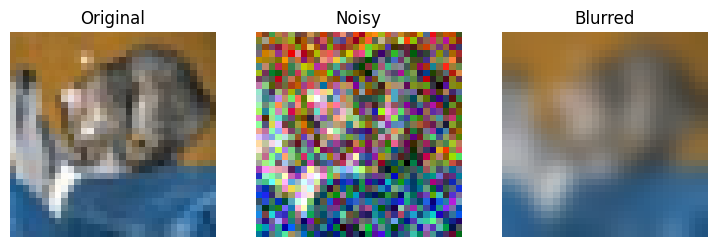


Original image prediction: [('a photo of a cat', 0.414794921875), ('a photo of a dog', 0.2117919921875), ('a photo of a ship', 0.10321044921875)]
Noisy image prediction: [('a photo of a bird', 0.25390625), ('a photo of a cat', 0.24609375), ('a photo of a dog', 0.1446533203125)]
Blurred image prediction: [('a photo of a airplane', 0.40185546875), ('a photo of a ship', 0.259521484375), ('a photo of a dog', 0.084228515625)]


In [14]:
# --- Robustness Test with CLIP on CIFAR-10 ---
# import torchvision
import torchvision.transforms as T
# import matplotlib.pyplot as plt

# Reload CLIP preprocess for consistency
# model, preprocess = clip.load("ViT-B/32", device=device)

# Download CIFAR-10 test set & pick one sample
cifar10 = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
img, label = cifar10[0]  # first test image
classes = cifar10.classes
print("True label:", classes[label])

# Create perturbations (noise and blur)
to_tensor = T.ToTensor()
to_pil = T.ToPILImage()

img_tensor = to_tensor(img)

# Add Gaussian noise
noisy_tensor = (img_tensor + 0.2*torch.randn_like(img_tensor)).clamp(0,1)
noisy_img = to_pil(noisy_tensor)

# Apply blur
blurred_img = T.GaussianBlur(11)(img)

# Visualize original vs perturbed
fig, axs = plt.subplots(1,3, figsize=(9,3))
for ax, im, title in zip(axs, [img, noisy_img, blurred_img], ["Original", "Noisy", "Blurred"]):
    ax.imshow(im)
    ax.set_title(title)
    ax.axis("off")
plt.show()

# Candidate text labels (CIFAR-10 classes)
text_prompts = [f"a photo of a {c}" for c in classes]
text_tokens = clip.tokenize(text_prompts).to(device)

def predict_with_clip(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = model.encode_image(image_input)
        text_feat = model.encode_text(text_tokens)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        text_feat /= text_feat.norm(dim=-1, keepdim=True)
        probs = (100.0 * img_feat @ text_feat.T).softmax(dim=-1)
    top_prob, top_idx = probs[0].topk(3)
    return [(text_prompts[i], top_prob[j].item()) for j,i in enumerate(top_idx)]

# Run predictions
print("\nOriginal image prediction:", predict_with_clip(img))
print("Noisy image prediction:", predict_with_clip(noisy_img))
print("Blurred image prediction:", predict_with_clip(blurred_img))


CLIP shape-bias: 89.8% | shape=8937, texture=1011, other=939


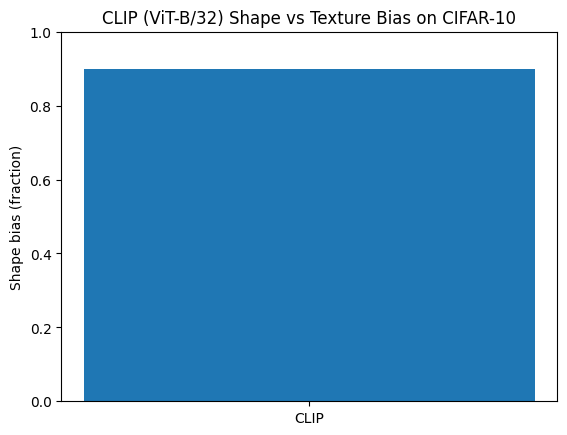

In [17]:
# CLIP Shape vs Texture Bias (CIFAR-10)
# import torch, clip
# import matplotlib.pyplot as plt
# from PIL import Image

# ----- Load CLIP -----
# device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

cifar10 = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

# X = images, y = labels
X = torch.stack([img for img, _ in cifar10])   # shape [10000, 3, 32, 32]
y_true = torch.tensor([lbl for _, lbl in cifar10])

y_shape = y_true
y_tex = torch.randint_like(y_true, 0, len(cifar10_classes))

# ----- CIFAR-10 classes -----
cifar10_classes = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# Prompt templates (simple)
templates = ["a photo of a {}", "a drawing of a {}"]

@torch.no_grad()
def build_text_prototypes(class_names, templates):
    texts = [tmpl.format(c) for c in class_names for tmpl in templates]
    tokens = clip.tokenize(texts).to(device)
    text_feats = clip_model.encode_text(tokens)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

    # average per class
    per_class = []
    for i in range(len(class_names)):
        f = text_feats[i*len(templates):(i+1)*len(templates)].mean(dim=0)
        per_class.append(f / f.norm())
    return torch.stack(per_class, dim=0)

text_protos = build_text_prototypes(cifar10_classes, templates)

# ----- Helpers -----
def to_clip_batch(X, idx):
    imgs = [clip_preprocess(transforms.ToPILImage()(X[i])) for i in idx]
    return torch.stack(imgs).to(device)

@torch.no_grad()
def eval_shape_texture_clip(X, y_shape, y_tex, batch=64):
    preds = []
    for start in range(0, len(X), batch):
        idx = list(range(start, min(start+batch, len(X))))
        imgs = to_clip_batch(X, idx)
        img_feats = clip_model.encode_image(imgs)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        logits = clip_model.logit_scale.exp() * img_feats @ text_protos.T
        preds.append(logits.argmax(dim=1).cpu())
    preds = torch.cat(preds)

    is_shape, is_tex = preds==y_shape, preds==y_tex
    s, t = int(is_shape.sum()), int(is_tex.sum())
    shape_bias = 100.0 * s / max(s+t, 1)
    return shape_bias, s, t, int((~(is_shape|is_tex)).sum())

# ----- Run -----
sb_clip, s, t, o = eval_shape_texture_clip(X, y_shape, y_tex)
print(f"CLIP shape-bias: {sb_clip:.1f}% | shape={s}, texture={t}, other={o}")

# Quick plot
plt.bar(["CLIP"], [sb_clip/100])
plt.ylim(0,1); plt.ylabel("Shape bias (fraction)")
plt.title("CLIP (ViT-B/32) Shape vs Texture Bias on CIFAR-10")
plt.show()

In [ ]:
# Shape vs Texture bias test (using Geirhos cue-conflict stimuli) — CLIP evaluation
# One cell: loads dataset, builds CLIP prototypes, evaluates shape vs texture responses.

# ---- Install / imports ----
try:
    import tensorflow_datasets as tfds
except Exception:
    import sys
    !{sys.executable} -m pip -q install tensorflow-datasets
    import tensorflow_datasets as tfds

import torch, clip
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- Config ----
device = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SAMPLES = 500        # limit number of cue-conflict images to evaluate (set None to use all)
TEMPLATES = ["a photo of a {}", "a drawing of a {}", "a sketch of a {}"]  # templates to average
EXAMPLES_TO_SHOW = 8     # show some example images for inspection

# ---- Load CLIP ----
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.eval()

# ---- Load Geirhos cue-conflict dataset (TFDS) ----
print("Loading Geirhos cue-conflict stimuli (this may download ~150MB the first time)...")
ds_tf, ds_info = tfds.load("geirhos_conflict_stimuli", split="test", with_info=True, as_supervised=False)
# ds_tf is a tf.data.Dataset; convert to numpy iterator
ds_iter = tfds.as_numpy(ds_tf)

# ---- Collect examples where shape_label != texture_label (cue-conflict samples) ----
examples = []
for ex in ds_iter:
    shape_lbl = int(ex["shape_label"])
    tex_lbl = int(ex["texture_label"])
    if shape_lbl != tex_lbl:   # cue-conflict
        examples.append({
            "image": ex["image"],           # numpy uint8 HxWx3
            "shape_label": shape_lbl,
            "texture_label": tex_lbl,
            "file_name": ex.get("file_name", b"").decode() if isinstance(ex.get("file_name", b""), (bytes, bytearray)) else ex.get("file_name", "")
        })
    if MAX_SAMPLES and len(examples) >= MAX_SAMPLES:
        break

n_examples = len(examples)
print(f"Collected {n_examples} cue-conflict examples (shape != texture).")

if n_examples == 0:
    raise RuntimeError("No cue-conflict examples found. Check dataset availability.")

# ---- Class names (16 classes) ----
class_names = ds_info.features["shape_label"].names  # list of 16 class names
print("Classes (16):", class_names)

# ---- Build averaged text prototypes (one vector per class) ----
print("Building text prototypes (averaging templates)...")
all_prompts = []
for cls in class_names:
    for t in TEMPLATES:
        all_prompts.append(t.format(cls))

# tokenize in batches (clip.tokenize handles a list)
with torch.no_grad():
    tokens = clip.tokenize(all_prompts).to(device)   # shape [16*len(TEMPLATES), token_len]
    text_embs = clip_model.encode_text(tokens)       # [16*len(TEMPLATES), D]
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)

# average per class across templates
D = text_embs.shape[-1]
n_templates = len(TEMPLATES)
protos = []
for i in range(len(class_names)):
    start = i * n_templates
    p = text_embs[start:start+n_templates].mean(dim=0)
    p = p / p.norm()
    protos.append(p)
text_protos = torch.stack(protos, dim=0)  # [16, D]
text_protos = text_protos.to(device)

# ---- Evaluate images in batches ----
print("Encoding images and computing predictions (CLIP)...")
batch_size = 32
shape_count = 0
texture_count = 0
other_count = 0

# Keep lists for per-class statistics and examples
per_class = {i: {"shape_count":0, "texture_count":0, "other":0, "total":0} for i in range(len(class_names))}
examples_shape = []
examples_texture = []

with torch.no_grad():
    for start in range(0, n_examples, batch_size):
        batch = examples[start:start+batch_size]
        # Prepare PIL images and preprocess
        pil_imgs = [Image.fromarray(ex["image"]) if isinstance(ex["image"], np.ndarray) else ex["image"] for ex in batch]
        imgs_tensor = torch.stack([clip_preprocess(im) for im in pil_imgs]).to(device)  # [B,C,H,W]
        img_feats = clip_model.encode_image(imgs_tensor)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

        # logits: scale * (img_feats @ text_protos^T)
        logits = clip_model.logit_scale.exp() * (img_feats @ text_protos.T)  # [B,16]
        preds = logits.argmax(dim=1).cpu().numpy()

        for i, ex in enumerate(batch):
            pred = int(preds[i])
            shape_lbl = ex["shape_label"]
            tex_lbl = ex["texture_label"]
            per_class[shape_lbl]["total"] += 1

            if pred == shape_lbl and pred == tex_lbl:
                # rare: predicted equals both (shape==texture) - not expected in filtered set
                per_class[shape_lbl]["shape_count"] += 1
                per_class[tex_lbl]["texture_count"] += 1
                shape_count += 1
                texture_count += 1
            elif pred == shape_lbl:
                shape_count += 1
                per_class[shape_lbl]["shape_count"] += 1
                # keep some example images
                if len(examples_shape) < EXAMPLES_TO_SHOW:
                    examples_shape.append((pil_imgs[i], class_names[shape_lbl], class_names[tex_lbl], pred))
            elif pred == tex_lbl:
                texture_count += 1
                per_class[shape_lbl]["texture_count"] += 1
                if len(examples_texture) < EXAMPLES_TO_SHOW:
                    examples_texture.append((pil_imgs[i], class_names[shape_lbl], class_names[tex_lbl], pred))
            else:
                other_count += 1
                per_class[shape_lbl]["other"] += 1

# ---- Summary metrics ----
print("\n=== Shape vs Texture Summary (CLIP) ===")
print(f"Total examples evaluated: {n_examples}")
print(f"Shape responses:   {shape_count}")
print(f"Texture responses: {texture_count}")
print(f"Other responses:   {other_count}")
shape_bias_pct = 100.0 * (shape_count / max((shape_count + texture_count), 1))
print(f"Shape bias (shape / (shape+texture)): {shape_bias_pct:.2f}%\n")

# Per-class breakdown (show classes with some samples)
print("Per-class breakdown (showing classes with any samples):")
for idx, cname in enumerate(class_names):
    t = per_class[idx]
    if t["total"] == 0:
        continue
    s = t["shape_count"]; tx = t["texture_count"]; o = t["other"]
    frac_shape = 100.0 * s / max((s+tx), 1) if (s+tx)>0 else float("nan")
    print(f" {cname:12s} | total={t['total']:3d} | shape={s:3d} | texture={tx:3d} | other={o:3d} | shape% (shape/(shape+texture)) = {frac_shape:5.1f}%")

# ---- Show some example images ----
def show_examples(ex_list, heading):
    if not ex_list:
        print(f"\nNo examples for {heading}")
        return
    print(f"\nExamples where CLIP chose {heading} (showing up to {len(ex_list)}):")
    n = len(ex_list)
    cols = min(4, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i, (img, shape_name, tex_name, pred) in enumerate(ex_list):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"shape={shape_name}\ntexture={tex_name}\npred={class_names[pred]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(examples_shape, "SHAPE")
show_examples(examples_texture, "TEXTURE")


Loading Geirhos cue-conflict stimuli (this may download ~150MB the first time)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]